### 📘 Scan-Lens Design for UV Applications (355 nm)

This notebook demonstrates how to design a **Scan lens** using **singlet lenses from Thorlabs**, specifically targeting **UV applications** such as **3D printing**, **laser engraving**, and potentially **scanning microscopy**.

The optical system is optimized for a **355 nm UV laser**, with the goal of focusing a collimated beam to a **spot size of 30–50 µm**. This spot size is suitable for a wide range of microscale fabrication and imaging applications.

---

### 🔍 Design Goals and Considerations

- **UV Compatibility**: All components are selected for **high transmission at 355 nm**, using **UV anti-reflection coatings** and **UV-grade fused silica substrates**.
- **Thermal and Optical Stability**: Materials are chosen for **low thermal expansion** and **high Laser-Induced Damage Threshold (LIDT)** to ensure stability under high-power UV exposure.
- **Field Flatness**: A primary design goal is to maintain a **flat image plane** across the field of view — a core property of scanning lenses.
The scan lens should therefore ensure that the spot displacement on the image plane is **proportional to the scan angle**.

---

### 🧠 Optical Strategy

- The system is configured such that the **net optical power is close to zero**, which helps minimize field curvature and distortion.
- A **long focal length** is used to convert small angular displacements of the scanning mirror into larger lateral displacements in the image plane. This increases scan precision but slightly enlarges the focused spot.
- The design targets a **moderate scan area** (e.g., 10×10 mm or less), keeping galvo deflection angles small to reduce angular distortion and off-axis aberrations.

---

This design represents a practical balance between **simplicity, cost, and optical performance**, leveraging readily available components to achieve high-quality scanning in the UV domain.


In [81]:
import optiland.backend as be
from optiland import optic, analysis, mtf
from optiland.materials import IdealMaterial
from optiland import optimization
from optiland.analysis import FieldCurvature
from optiland.analysis import RmsSpotSizeVsField
from optiland.analysis import ThroughFocusSpotDiagram

We start by defining the aperture type to be EPD, to replicate the behaviour of a collimated beam. We will choose the diameter to be 10 mm, since lasers commonly have at least a few mms diameter.

In [82]:
lens = optic.Optic()
# add aperture
lens.set_aperture(aperture_type="EPD", value=10)

The combination of lenses we would be choosing would be a combination of plano-concave and plano-convex lenses from Thorlabs, with focal lengths of -75mm, +100mm, +300mm respectively(Lens models :  LC4513-**UV**, LA - 4545-**UV**, LA-4855-**UV**). They are made of **UV** grade Fused Silica and have anti-reflective coatings that should suffice for applications with moderate laser power. Moreover, The two inch lenses provide sufficient clear aperture which could be effectively used for scanning purposes.

We will first position the plano-convex and plano-concave lenses such that the plane surfaces face each other. We choose the distance between the two lenses to be about 25 mm.

In [83]:
uvfs = IdealMaterial(n=1.476, k=0)  # define fused silica's refractive index at 355 nm
lens.add_surface(index=0, thickness=be.inf, radius=be.inf)
lens.add_surface(index=1, radius=-34.5, thickness=3.5, material=uvfs, is_stop=True)
lens.add_surface(index=2, radius=be.inf, thickness=25)
lens.add_surface(index=3, radius=be.inf, thickness=10.640, material=uvfs)
lens.add_surface(index=4, radius=-46, thickness=20)

The focusing lens is then inserted at about 20 mm downstream and the image plane is kept at about 300 mm from the last surface.

In [84]:
lens.add_surface(index=5, radius=138.020, thickness=5.350, material=uvfs)
lens.add_surface(index=6, radius=be.inf, thickness=300)
lens.add_surface(index=7)

Setting the field angles and the primary wavelength and performing the raytrace, we see that the lenses need significant positioning adjustment to reach an optimal focus condition.

In [85]:
# add field
lens.set_field_type(field_type="angle")
lens.add_field(y=0)
lens.add_field(y=5)
lens.add_field(y=7)

# add wavelength
lens.add_wavelength(value=0.355, is_primary=True)

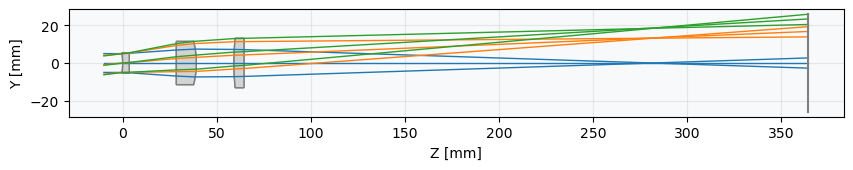

In [86]:
lens.draw()

We use the optimizer to determine the best distances between the lenses to minimize the RMS spot size at the maximum field angle. The 

In [87]:
problem = optimization.OptimizationProblem()

input_data = {
    "optic": lens,
    "surface_number": -1,
    "Hx": 0,
    "Hy": 1,
    "num_rays": 5,
    "wavelength": 0.355,
    "distribution": "hexapolar",
}

# add RMS spot size operand
problem.add_operand(
    operand_type="rms_spot_size",
    target=0,
    weight=1,
    input_data=input_data,
)

In [88]:
problem.add_variable(lens, "thickness", surface_number=2)
problem.add_variable(lens, "thickness", surface_number=4)
problem.add_variable(lens, "thickness", surface_number=6)

In [89]:
optimizer = optimization.OptimizerGeneric(problem)
optimizer.optimize()

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.0031936552616738806
        x: [ 3.224e-01  1.000e+00  2.884e+01]
      nit: 3
      jac: [ 2.953e-04  5.989e-05  1.232e-04]
     nfev: 16
     njev: 4
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [90]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │             0.00319366 │           99.9263 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ rms spot size  │        0 │              │              │        1 │   0.057 │   0.057 │            100 │
╘════╧════════════════╧══════════╧══════════════╧══════════════╧══════════╧═════════╧═════════╧════════════════╛
╒════╤═════════════════╤═══════════╤══════════╤══════════════╤══════════════╕
│    │ Variable Type   │   Surface │    Value │ Min. Bound   │ Max. Bound   │
╞════╪═════════════

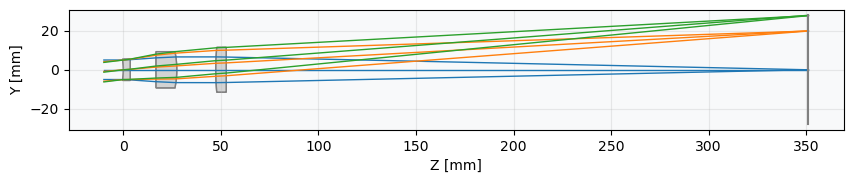

In [91]:
lens.draw()

The results after optimization indicate that for angles close to zero and hence within a scan field less than 5mmx5mm, the system could in theory provide near diffraction-limited performance.

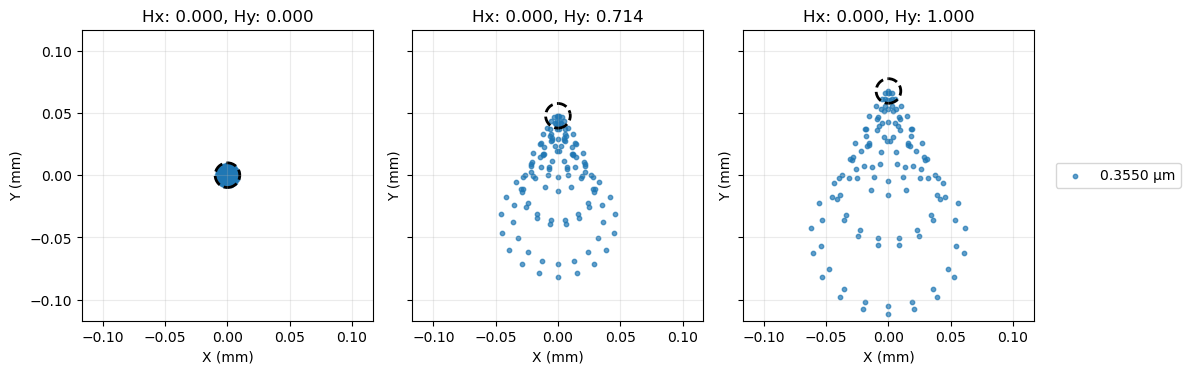

In [92]:
spot = analysis.SpotDiagram(lens)
spot.view(add_airy_disk=True)

The field curvature plot indicates that the field is fairly flat over the angles that we are interested in. However, the focus plane appears to be shifted axially, which would need to be compensated for.

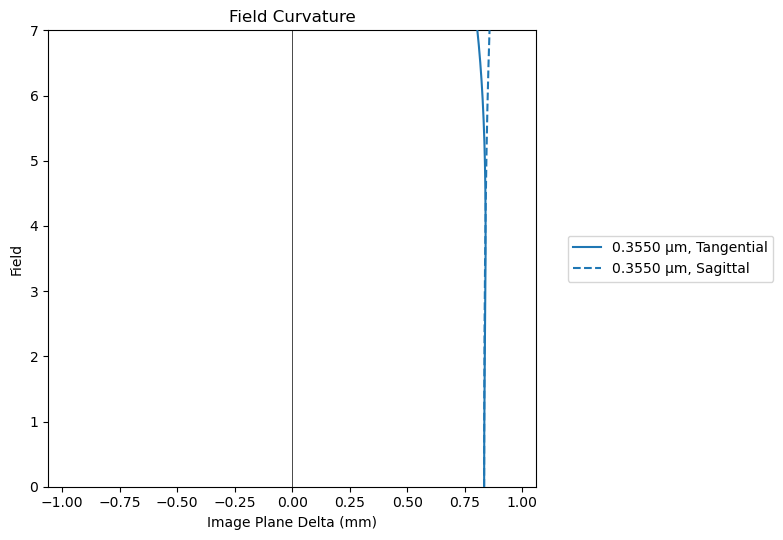

In [93]:
field_curvature = FieldCurvature(lens)
field_curvature.view()

All the remaining analysis plots indicate that a resolution better than 50 microns is possible, for field angles up to 5 degrees.

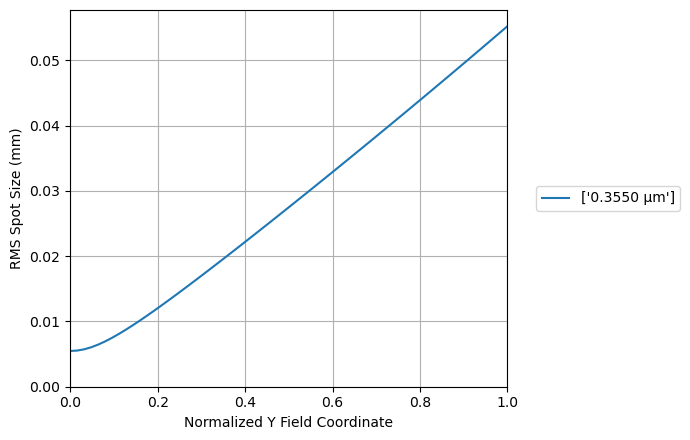

In [94]:
rms_vs_field = RmsSpotSizeVsField(lens)
rms_vs_field.view()

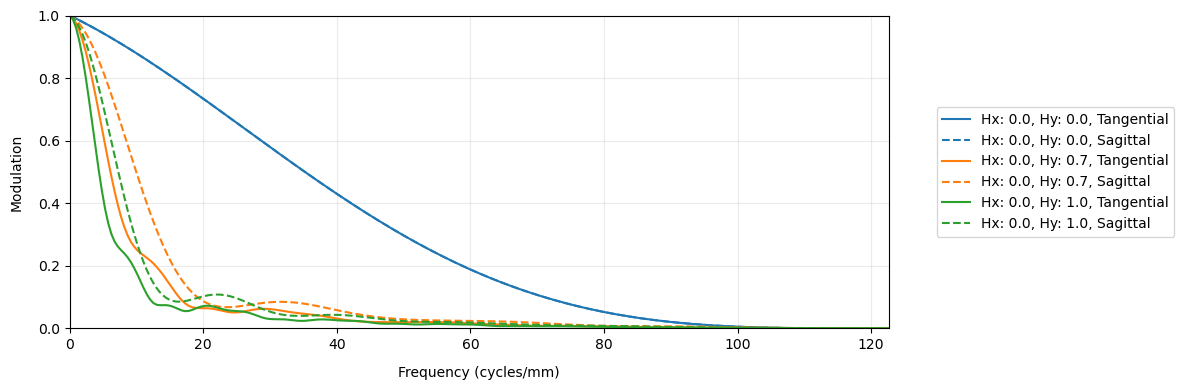

In [95]:
geo_mtf = mtf.GeometricMTF(lens)
geo_mtf.view()

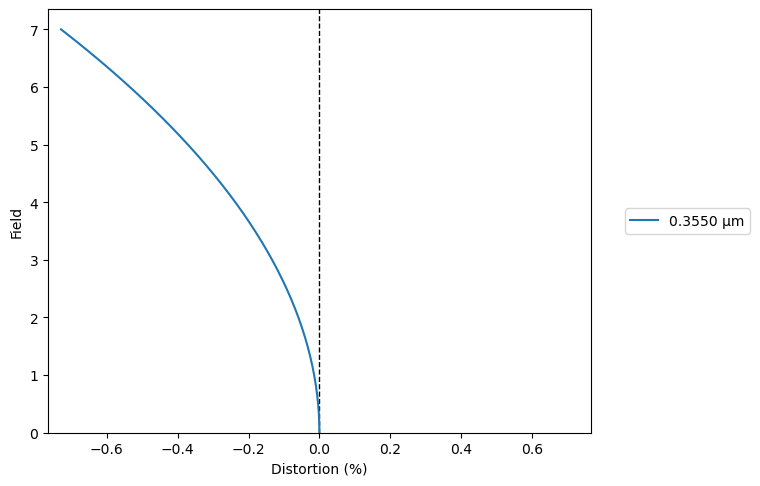

In [96]:
distortion = analysis.Distortion(lens)
distortion.view()

To conclude, we can hence build a simple scanning lens system for applications such as **UV** polymerization, microfluidics and laser induced flourescence excitation to name a few. The system demonstrated above can in principle be used with visible light as well, albeit with slightly different distances. Thorlabs offers the same lenses but with a different coating for the 400-700 nm wavelength range and hence, the design could be used for a variety of wavelengths between 250-700 nm.